In [1]:
## Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import unicodedata
import spacy

import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report,precision_score,recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df_data = pd.read_csv('dqp_cleaned_data.csv')

In [ ]:
df_data.shape

In [3]:
df_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned_text,question2_cleaned_text,q1_len,q2_len,...,word_total,word_share,cwc_min,cwc_max,first_word_eq,last_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,good marketing automation tool small mid size ...,good marketing automation tool small mid sized...,53,54,...,16,0.44,0.875000,0.875,1,1,99,98,99,99
1,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,poor want invest,quite poor want rich,16,20,...,7,0.29,0.666667,0.500,0,0,61,73,50,72
2,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,india live abroad meet guy france party.i want...,t.i.e.t thapar university thapar university in...,51,96,...,18,0.00,0.000000,0.000,0,0,29,39,33,31
3,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,many people u.s hate southern state,boyfriend do not feel guilty hurt cry tell kil...,35,74,...,19,0.00,0.000000,0.000,0,0,17,37,24,24
4,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,30,32,...,9,0.33,0.750000,0.600,0,1,74,79,58,75


In [4]:
df_data.shape

(99999, 23)

In [5]:
df_data.isnull().sum()

id                         0
qid1                       0
qid2                       0
question1                  0
question2                  0
is_duplicate               0
question1_cleaned_text    18
question2_cleaned_text    16
q1_len                     0
q2_len                     0
q1_words                   0
q2_words                   0
word_common                0
word_total                 0
word_share                 0
cwc_min                    0
cwc_max                    0
first_word_eq              0
last_word_eq               0
fuzz_ratio                 0
fuzz_partial_ratio         0
token_sort_ratio           0
token_set_ratio            0
dtype: int64

In [6]:
df_data.dropna(axis = 0,inplace = True)
df_data = df_data.reset_index(drop = True)

In [7]:
## remove unwanted columns 

df_raw = df_data.drop(columns = ['id','qid1','qid2','question1','question2'],axis = 1)

In [8]:
df_raw.head()

,is_duplicate,question1_cleaned_text,question2_cleaned_text,q1_len,q2_len,q1_words,q2_words,word_common,word_total,word_share,cwc_min,cwc_max,first_word_eq,last_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,1,good marketing automation tool small mid size ...,good marketing automation tool small mid sized...,53,54,8,8,7,16,0.44,0.875000,0.875,1,1,99,98,99,99
1,0,poor want invest,quite poor want rich,16,20,3,4,2,7,0.29,0.666667,0.500,0,0,61,73,50,72
2,0,india live abroad meet guy france party.i want...,t.i.e.t thapar university thapar university in...,51,96,9,11,0,18,0.00,0.000000,0.000,0,0,29,39,33,31
3,0,many people u.s hate southern state,boyfriend do not feel guilty hurt cry tell kil...,35,74,6,13,0,19,0.00,0.000000,0.000,0,0,17,37,24,24
4,0,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,30,32,4,5,3,9,0.33,0.750000,0.600,0,1,74,79,58,75


In [9]:
df_raw.shape

(99967, 18)

## TF - IDF vectorizer

#### Separate Fitting and Transforming:
- When you use tfidf.fit_transform on both question columns separately, the TF-IDF model is fitted independently on each column. This means the vocabulary and IDF (Inverse Document Frequency) scores for question1_cleaned_text and question2_cleaned_text will be different. To have a consistent TF-IDF transformation, it's better to fit the model on the combined text from both questions and then transform each question separately.

#### Combining TF-IDF Vectors: 
- Concatenating the TF-IDF vectors of both questions is a valid approach. This will create a feature vector for each pair of questions which can be used for training a model to detect duplicates.


- By fitting the TF-IDF vectorizer on the combined texts from both questions, you ensure that the same vocabulary and IDF scores are used for both question columns.

In [10]:
pd.concat([df_raw['question1_cleaned_text'], df_raw['question2_cleaned_text']])

0        good marketing automation tool small mid size ...
1                                         poor want invest
2        india live abroad meet guy france party.i want...
3                      many people u.s hate southern state
4                           consequence bhopal gas tragedy
                               ...                        
99962                         people live reason live life
99963                  train golden retriever dog blue eye
99964                     good way learn computer language
99965    good idea small industry start capital rs.10 lakh
99966                            productive insurance sale
Length: 199934, dtype: object

In [11]:
## Combine the Texts for Fitting

df_combined_texts = pd.concat([df_raw['question1_cleaned_text'], df_raw['question2_cleaned_text']])
tfidf = TfidfVectorizer(ngram_range = (1,1),min_df = 5,max_df = 0.9,strip_accents = 'unicode',
                        max_features = 1000).fit(df_combined_texts)


In [12]:
tfidf

TfidfVectorizer(max_df=0.9, max_features=1000, min_df=5,
                strip_accents='unicode')

In [13]:
## Transform the Questions Separately

In [14]:
tfidf_matrix_q1 = tfidf.transform(df_raw['question1_cleaned_text'])
tfidf_matrix_q2 = tfidf.transform(df_raw['question2_cleaned_text'])

In [15]:
## Convert Sparse Matrix to DataFrame

tfidf_df_q1 = pd.DataFrame(tfidf_matrix_q1.toarray(), columns=[f'q1_{i}' for i in range(tfidf_matrix_q1.shape[1])])
tfidf_df_q2 = pd.DataFrame(tfidf_matrix_q2.toarray(), columns=[f'q2_{i}' for i in range(tfidf_matrix_q2.shape[1])])


In [16]:
## Concatenate the TF-IDF DataFrames

In [17]:
df_final_tfidf_combined = pd.concat([df_raw.drop(columns=['question1_cleaned_text', 'question2_cleaned_text'], 
                                        axis=1), tfidf_df_q1, tfidf_df_q2], axis=1)
#df_final_tfidf_combined = pd.concat([df_raw['is_duplicate'],tfidf_df_q1, tfidf_df_q2], axis=1)

In [18]:
df_final_tfidf_combined.head()

,is_duplicate,q1_len,q2_len,q1_words,q2_words,word_common,word_total,word_share,cwc_min,cwc_max,...,q2_990,q2_991,q2_992,q2_993,q2_994,q2_995,q2_996,q2_997,q2_998,q2_999
0,1,53,54,8,8,7,16,0.44,0.875000,0.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0,16,20,3,4,2,7,0.29,0.666667,0.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0,51,96,9,11,0,18,0.00,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0,35,74,6,13,0,19,0.00,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.367751,0.0,0.0
4,0,30,32,4,5,3,9,0.33,0.750000,0.600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


#### Note : 
- Subtracting the TF-IDF vectors of the two questions is another approach that can be useful for detecting duplicate questions. 
- This approach creates a difference vector that captures the dissimilarity between the two questions.
- It can help in reducing dimensionality while preserving important information about the differences between the questions.

In [19]:
difference_matrix = tfidf_matrix_q1 - tfidf_matrix_q2
df_difference = pd.DataFrame(difference_matrix.toarray(), 
                             columns=[f'diff_{i}' for i in range(difference_matrix.shape[1])])


In [20]:
df_difference.head()

,diff_0,diff_1,diff_2,diff_3,diff_4,diff_5,diff_6,diff_7,diff_8,diff_9,...,diff_990,diff_991,diff_992,diff_993,diff_994,diff_995,diff_996,diff_997,diff_998,diff_999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.367751,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [21]:
df_final_tfidf_diff = pd.concat([df_raw.drop(columns=['question1_cleaned_text', 'question2_cleaned_text'], axis=1), 
                                 df_difference], axis=1)
#df_final_tfidf_diff = pd.concat([df_raw['is_duplicate'],df_difference], axis=1)

In [22]:
df_final_tfidf_combined.shape,df_final_tfidf_diff.shape

((99967, 2016), (99967, 1016))

### PCA (Principle Component Analysis)

In [23]:
from sklearn.decomposition import PCA

In [24]:
target_tfidf_combined = df_final_tfidf_combined['is_duplicate']
features_tfidf_combined = df_final_tfidf_combined.drop(columns=['is_duplicate'],axis = 1)

target_tfidf_diff = df_final_tfidf_diff['is_duplicate']
features_tfidf_diff = df_final_tfidf_diff.drop(columns=['is_duplicate'],axis = 1)

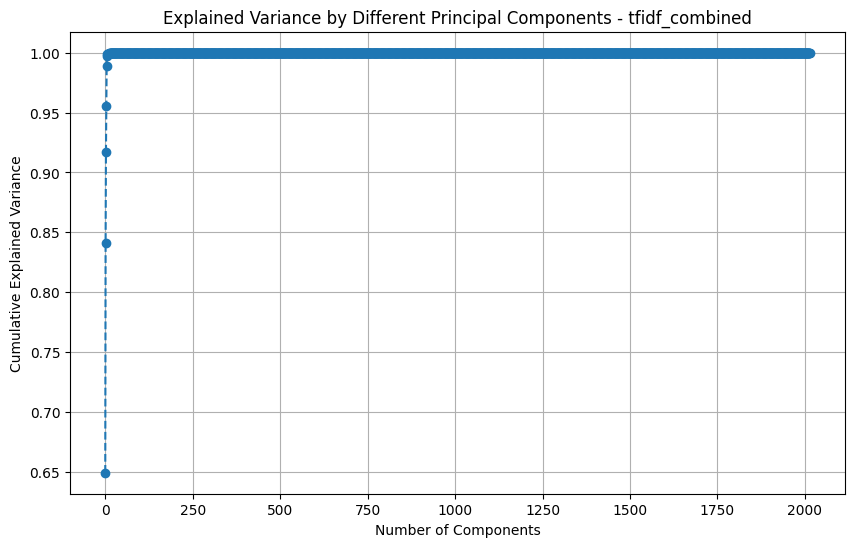

In [25]:
# Fit PCA to the feature data without specifying the number of components
pca = PCA()
pca.fit(features_tfidf_combined)

# Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components - tfidf_combined')
plt.grid(True)
plt.show()

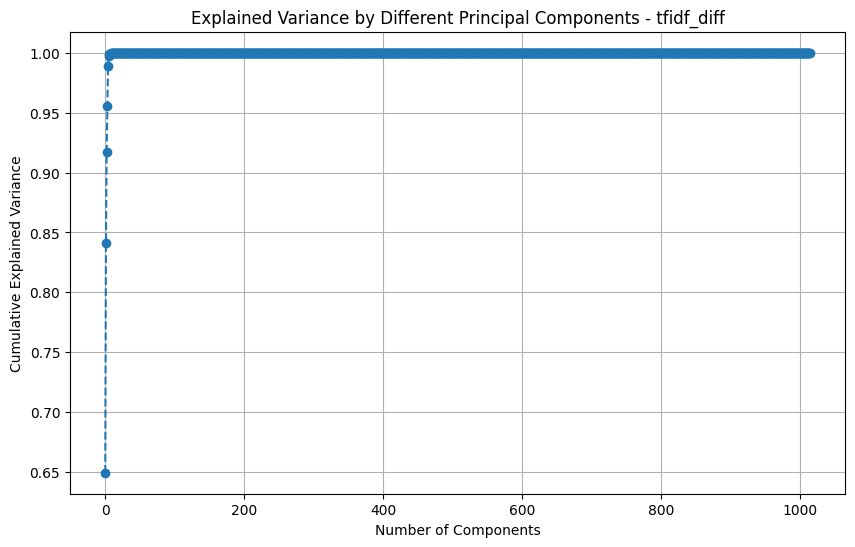

In [26]:
# Fit PCA to the feature data without specifying the number of components
pca = PCA()
pca.fit(features_tfidf_diff)

# Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components - tfidf_diff')
plt.grid(True)
plt.show()

In [27]:
# Set the number of components to the chosen value based on the plot

pca_combine = PCA(n_components=500)
pca_diff = PCA(n_components=200)

In [28]:
# Apply PCA
pca_matrix_tfidf_combined = pca_combine.fit_transform(features_tfidf_combined)
pca_matrix_tfidf_diff = pca_diff.fit_transform(features_tfidf_diff)

# Convert PCA matrix to DataFrame
df_pca_tfidf_combined = pd.DataFrame(pca_matrix_tfidf_combined, columns=[f'pca_{i}' for i in range(500)])
df_pca_tfidf_diff = pd.DataFrame(pca_matrix_tfidf_diff, columns=[f'pca_{i}' for i in range(200)])

# Combine PCA components with target column
df_final_pca_tfidf_combined = pd.concat([df_pca_tfidf_combined,target_tfidf_combined.reset_index(drop=True)], axis=1)
df_final_pca_tfidf_diff = pd.concat([df_pca_tfidf_diff,target_tfidf_diff.reset_index(drop=True)], axis=1)


In [29]:
df_final_pca_tfidf_combined.shape,df_final_pca_tfidf_diff.shape

((99967, 501), (99967, 201))

## Word2vec 

#### 1. Concatenate Vectors (Current Approach)
- This is your current approach where you concatenate the average Word2Vec vectors of both questions. This method is straightforward and captures the information from both questions.

#### 2. Difference Vectors
- Subtract the average Word2Vec vector of the second question from the first. This captures the difference in semantics between the two questions.

#### 3. Combined Approach
- You can combine both the concatenated vectors and the difference vectors to create a richer feature set.

In [30]:
#!pip install gensim

In [31]:
import gensim.downloader as api
from gensim.models import Word2Vec

In [32]:
# Load the pre-trained Word2Vec model
model_w2vec = api.load("word2vec-google-news-300")

# Verify the model is loaded
print(model_w2vec)

KeyedVectors<vector_size=300, 3000000 keys>


In [33]:
# Find the most similar words to 'king'
similar_words = model_w2vec.most_similar('king')
print(similar_words)

[('kings', 0.7138046622276306), ('queen', 0.6510956287384033), ('monarch', 0.6413194537162781), ('crown_prince', 0.6204219460487366), ('prince', 0.6159993410110474), ('sultan', 0.5864824056625366), ('ruler', 0.5797566771507263), ('princes', 0.5646552443504333), ('Prince_Paras', 0.5432944297790527), ('throne', 0.5422105193138123)]


In [34]:
#model_w2vec['hi']

In [35]:
vector_size = 300
def get_average_word2vec(tokens):
    # Get Word2Vec vectors for each token
    vectors = [model_w2vec[token] for token in tokens if token in model_w2vec]
    
    if not vectors:
        # Return a vector of zeros if no tokens are in the model
        return np.zeros(vector_size)
    
    # Calculate the average vector for every setence (text)
    avg_vector = np.mean(vectors, axis=0)
    return avg_vector

In [36]:
# Apply the get_average_word2vec function to each row

w2vec_q1 = df_raw['question1_cleaned_text'].apply(func=get_average_word2vec)
w2vec_q2 = df_raw['question2_cleaned_text'].apply(func=get_average_word2vec)

In [37]:
w2vec_q1_df = pd.DataFrame(data = list(w2vec_q1),columns=[f'vec_q1_{i}' for i in range(vector_size)])
w2vec_q2_df = pd.DataFrame(data = list(w2vec_q2),columns=[f'vec_q2_{i}' for i in range(vector_size)])

In [38]:
w2vec_q1_df.shape,w2vec_q2_df.shape

((99967, 300), (99967, 300))

In [39]:
df_final_w2vec_combined = pd.concat([df_raw.drop(columns = ['question1_cleaned_text','question2_cleaned_text'],axis = 1),
                     w2vec_q1_df,w2vec_q2_df], axis = 1)

#df_final_w2vec_combined = pd.concat([df_raw['is_duplicate'],w2vec_q1_df,w2vec_q2_df], axis = 1)

In [40]:
difference_vectors = w2vec_q1_df.values - w2vec_q2_df.values
df_w2vec_diff = pd.DataFrame(data=difference_vectors, columns=[f'diff_vec_{i}' for i in range(vector_size)])

In [41]:
df_final_w2vec_diff = pd.concat([df_raw.drop(columns = ['question1_cleaned_text','question2_cleaned_text'],axis = 1),
                    df_w2vec_diff], axis = 1)

#df_final_w2vec_diff = pd.concat([df_raw['is_duplicate'],df_w2vec_diff], axis = 1)

In [42]:
df_final_w2vec_combined.shape,df_final_w2vec_diff.shape

((99967, 616), (99967, 316))

### Spliting features & target values

In [43]:
## tfidf
x_tfidf_combine = df_final_tfidf_combined.drop(columns="is_duplicate",axis=1)
y_tfidf_combine = df_final_tfidf_combined["is_duplicate"]

x_tfidf_diff = df_final_tfidf_diff.drop(columns="is_duplicate",axis=1)
y_tfidf_diff = df_final_tfidf_diff["is_duplicate"]

### tfidf pca

x_tfidf_pca_combine = df_final_pca_tfidf_combined.drop(columns="is_duplicate",axis=1)
y_tfidf_pca_combine = df_final_pca_tfidf_combined["is_duplicate"]

x_tfidf_pca_diff = df_final_pca_tfidf_diff.drop(columns="is_duplicate",axis=1)
y_tfidf_pca_diff = df_final_pca_tfidf_diff["is_duplicate"]

## word2vec
x_w2vec_combine = df_final_w2vec_combined.drop(columns="is_duplicate",axis=1)
y_w2vec_combine = df_final_w2vec_combined["is_duplicate"]

x_w2vec_diff = df_final_w2vec_diff.drop(columns="is_duplicate",axis=1)
y_w2vec_diff = df_final_w2vec_diff["is_duplicate"]

In [44]:
## Change datatype of target from object to int64
y_tfidf_combine = y_tfidf_combine.astype("int64")
y_tfidf_diff = y_tfidf_diff.astype("int64")

y_tfidf_pca_combine = y_tfidf_pca_combine.astype("int64")
y_tfidf_pca_diff = y_tfidf_pca_diff.astype("int64")

y_w2vec_combine = y_w2vec_combine.astype("int64")
y_w2vec_diff = y_w2vec_diff.astype("int64")

### Spliting data into train and test

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
## tfidf

x_train_tfidf_combine,x_test_tfidf_combine,y_train_tfidf_combine,y_test_tfidf_combine = train_test_split(x_tfidf_combine,y_tfidf_combine,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_tfidf_combine)


x_train_tfidf_diff,x_test_tfidf_diff,y_train_tfidf_diff,y_test_tfidf_diff = train_test_split(x_tfidf_diff,y_tfidf_diff,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_tfidf_diff)

## tfidf pca

x_train_tfidf_pca_combine,x_test_tfidf_pca_combine,y_train_tfidf_pca_combine,y_test_tfidf_pca_combine = train_test_split(x_tfidf_pca_combine,y_tfidf_pca_combine,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_tfidf_pca_combine)

x_train_tfidf_pca_diff,x_test_tfidf_pca_diff,y_train_tfidf_pca_diff,y_test_tfidf_pca_diff = train_test_split(x_tfidf_pca_diff,y_tfidf_pca_diff,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_tfidf_pca_diff)


In [47]:
## word2vec

x_train_w2vec_combine,x_test_w2vec_combine,y_train_w2vec_combine,y_test_w2vec_combine = train_test_split(x_w2vec_combine,y_w2vec_combine,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_w2vec_combine)


x_train_w2vec_diff,x_test_w2vec_diff,y_train_w2vec_diff,y_test_w2vec_diff = train_test_split(x_w2vec_diff,y_w2vec_diff,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_w2vec_diff)

In [48]:
x_train_tfidf_combine.shape, x_test_tfidf_combine.shape, y_train_tfidf_combine.shape, y_test_tfidf_combine.shape

((69976, 2015), (29991, 2015), (69976,), (29991,))

In [49]:
x_train_w2vec_combine.shape,x_test_w2vec_combine.shape,y_train_w2vec_combine.shape,y_test_w2vec_combine.shape

((69976, 615), (29991, 615), (69976,), (29991,))

### Standardization

In [50]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()

In [51]:
## tfidf 

x_train_tfidf_combine = scaler.fit_transform(x_train_tfidf_combine)
x_test_tfidf_combine = scaler.transform(x_test_tfidf_combine)

x_train_tfidf_diff = scaler.fit_transform(x_train_tfidf_diff)
x_test_tfidf_diff = scaler.transform(x_test_tfidf_diff)

## tfidf pca

x_train_tfidf_pca_combine = scaler.fit_transform(x_train_tfidf_pca_combine)
x_test_tfidf_pca_combine = scaler.transform(x_test_tfidf_pca_combine)

x_train_tfidf_pca_diff = scaler.fit_transform(x_train_tfidf_pca_diff)
x_test_tfidf_pca_diff = scaler.transform(x_test_tfidf_pca_diff)

In [52]:
### word2vec

x_train_w2vec_combine = scaler.fit_transform(x_train_w2vec_combine)
x_test_w2vec_combine = scaler.transform(x_test_w2vec_combine)

x_train_w2vec_diff = scaler.fit_transform(x_train_w2vec_diff)
x_test_w2vec_diff = scaler.transform(x_test_w2vec_diff)

## Logistic regression - base model

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold

#Stratified k-Fold Cross Validation with shuffle split 
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

### Hyperparameter tuning using Grid search 

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
model_log = LogisticRegression(class_weight='balanced',verbose=10,random_state=11,n_jobs=-1,
                              solver = 'saga',max_iter=1000)

In [56]:
# Define the hyperparameter grid
param_grid_log = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # Only used if penalty is 'elasticnet'
}

In [57]:
# Define the GridSearchCV
grid_search_log = GridSearchCV(estimator=model_log, param_grid=param_grid_log, 
                           cv=3, n_jobs=-1, scoring='f1', verbose=10)

# Fit the model
#grid_search_log.fit(x_train_tfidf,y_train_tfidf)

# Predict the labels
#predicted_labels = grid_search_log.predict(X_test)

# Evaluate the model
#best_params_log = grid_search_log.best_params_
#print(f"Best parameters: {best_params_log}")

In [58]:
# Save the best model to a pickle file

#with open('best_model_logistic.pkl', 'wb') as f:
    #pickle.dump(grid_search_log.best_estimator_, f)

In [59]:
# Load the best model from the pickle file
#with open('best_model_logistic.pkl', 'rb') as f:
    #best_model_logistic = pickle.load(f)

# Use the loaded model to predict the labels
#y_test_predict_log = best_model_logistic.predict(x_test_tfidf)

In [60]:
model_log_tfidf_combine = LogisticRegression(penalty='l2',class_weight='balanced',verbose=10,random_state=11,n_jobs=-1,
                              solver = 'saga',max_iter=1000)

model_log_tfidf_diff = LogisticRegression(penalty='l2',class_weight='balanced',verbose=10,random_state=11,n_jobs=-1,
                              solver = 'saga',max_iter=1000)

model_log_tfidf_pca_combine = LogisticRegression(penalty='l2',class_weight='balanced',verbose=10,random_state=11,n_jobs=-1,
                              solver = 'saga',max_iter=1000)
model_log_tfidf_pca_diff = LogisticRegression(penalty='l2',class_weight='balanced',verbose=10,random_state=11,n_jobs=-1,
                              solver = 'saga',max_iter=1000)

In [61]:
model_log_w2vec_combine = LogisticRegression(penalty='l2',class_weight='balanced',verbose=10,random_state=11,n_jobs=-1,
                              solver = 'saga',max_iter=1000)
model_log_w2vec_diff = LogisticRegression(penalty='l2',class_weight='balanced',verbose=10,random_state=11,n_jobs=-1,
                              solver = 'saga',max_iter=1000)

In [62]:
## tfidf embedding combine
model_log_tfidf_combine.fit(x_train_tfidf_combine,y_train_tfidf_combine)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 394 epochs took 270 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.5min


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=11, solver='saga', verbose=10)

In [63]:
## tfidf embedding diff
model_log_tfidf_diff.fit(x_train_tfidf_diff,y_train_tfidf_diff)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20161182
Epoch 3, change: 0.14906113
Epoch 4, change: 0.10482839
Epoch 5, change: 0.08652884
Epoch 6, change: 0.06715548
Epoch 7, change: 0.05590809
Epoch 8, change: 0.05082437
Epoch 9, change: 0.04300940
Epoch 10, change: 0.03724668
Epoch 11, change: 0.03269939
Epoch 12, change: 0.02964869
Epoch 13, change: 0.02691928
Epoch 14, change: 0.02497573
Epoch 15, change: 0.02314252
Epoch 16, change: 0.02143144
Epoch 17, change: 0.01985853
Epoch 18, change: 0.01857303
Epoch 19, change: 0.01738184
Epoch 20, change: 0.01628236
Epoch 21, change: 0.01526262
Epoch 22, change: 0.01431343
Epoch 23, change: 0.01348472
Epoch 24, change: 0.01264992
Epoch 25, change: 0.01190421
Epoch 26, change: 0.01124982
Epoch 27, change: 0.01069562
Epoch 28, change: 0.01004246
Epoch 29, change: 0.00955779
Epoch 30, change: 0.00899838
Epoch 31, change: 0.00857972
Epoch 32, change: 0.00827126
Epoch 33, change: 0.00788730
Epoch 34, change: 0.00758626
Epoch 35, change: 0.007

Epoch 161, change: 0.00265205
Epoch 162, change: 0.00263791
Epoch 163, change: 0.00262922
Epoch 164, change: 0.00261833
Epoch 165, change: 0.00260593
Epoch 166, change: 0.00259807
Epoch 167, change: 0.00258377
Epoch 168, change: 0.00257427
Epoch 169, change: 0.00256286
Epoch 170, change: 0.00255403
Epoch 171, change: 0.00254239
Epoch 172, change: 0.00253399
Epoch 173, change: 0.00252240
Epoch 174, change: 0.00251082
Epoch 175, change: 0.00250073
Epoch 176, change: 0.00249081
Epoch 177, change: 0.00248003
Epoch 178, change: 0.00247217
Epoch 179, change: 0.00246178
Epoch 180, change: 0.00245142
Epoch 181, change: 0.00244319
Epoch 182, change: 0.00243341
Epoch 183, change: 0.00242180
Epoch 184, change: 0.00241488
Epoch 185, change: 0.00240521
Epoch 186, change: 0.00239447
Epoch 187, change: 0.00238468
Epoch 188, change: 0.00237795
Epoch 189, change: 0.00236748
Epoch 190, change: 0.00235934
Epoch 191, change: 0.00235035
Epoch 192, change: 0.00234081
Epoch 193, change: 0.00233005
Epoch 194,

Epoch 707, chamax_iter reached after 321 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.4min


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=11, solver='saga', verbose=10)

In [64]:
## tfidf embedding pca combine
model_log_tfidf_pca_combine.fit(x_train_tfidf_pca_combine,y_train_tfidf_pca_combine)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 14 epochs took 3 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=11, solver='saga', verbose=10)

In [65]:
## tfidf embedding pca diff
model_log_tfidf_pca_diff.fit(x_train_tfidf_pca_diff,y_train_tfidf_pca_diff)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 14 epochs took 1 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=11, solver='saga', verbose=10)

In [66]:
## word2vec embedding combine
model_log_w2vec_combine.fit(x_train_w2vec_combine,y_train_w2vec_combine)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


nge: 0.00060938
Epoch 708, change: 0.00060836
Epoch 709, change: 0.00060692
Epoch 710, change: 0.00060611
Epoch 711, change: 0.00060471
Epoch 712, change: 0.00060367
Epoch 713, change: 0.00060269
Epoch 714, change: 0.00060136
Epoch 715, change: 0.00060047
Epoch 716, change: 0.00059922
Epoch 717, change: 0.00059799
Epoch 718, change: 0.00059693
Epoch 719, change: 0.00059586
Epoch 720, change: 0.00059479
Epoch 721, change: 0.00059368
Epoch 722, change: 0.00059262
Epoch 723, change: 0.00059155
Epoch 724, change: 0.00059029
Epoch 725, change: 0.00058925
Epoch 726, change: 0.00058817
Epoch 727, change: 0.00058721
Epoch 728, change: 0.00058597
Epoch 729, change: 0.00058499
Epoch 730, change: 0.00058372
Epoch 731, change: 0.00058279
Epoch 732, change: 0.00058172
Epoch 733, change: 0.00058045
Epoch 734, change: 0.00057962
Epoch 735, change: 0.00057851
Epoch 736, change: 0.00057739
Epoch 737, change: 0.00057643
Epoch 738, change: 0.00057545
Epoch 739, change: 0.00057403
Epoch 740, change: 0.000

Epoch 232, change: 0.00154221
Epoch 233, change: 0.00153581
Epoch 234, change: 0.00153045
Epoch 235, change: 0.00152467
Epoch 236, change: 0.00151920
Epoch 237, change: 0.00151413
Epoch 238, change: 0.00150933
Epoch 239, change: 0.00150261
Epoch 240, change: 0.00149779
Epoch 241, change: 0.00149294
Epoch 242, change: 0.00148673
Epoch 243, change: 0.00148238
Epoch 244, change: 0.00147525
Epoch 245, change: 0.00147235
Epoch 246, change: 0.00146705
Epoch 247, change: 0.00146095
Epoch 248, change: 0.00145628
Epoch 249, change: 0.00145085
Epoch 250, change: 0.00144666
Epoch 251, change: 0.00144187
Epoch 252, change: 0.00143565
Epoch 253, change: 0.00143131
Epoch 254, change: 0.00142661
Epoch 255, change: 0.00142168
Epoch 256, change: 0.00141738
Epoch 257, change: 0.00141175
Epoch 258, change: 0.00140690
Epoch 259, change: 0.00140326
Epoch 260, change: 0.00139750
Epoch 261, change: 0.00139354
Epoch 262, change: 0.00138873
Epoch 263, change: 0.00138509
Epoch 264, change: 0.00137976
Epoch 265,

Epoch 778, change: 0.00max_iter reached after 202 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.4min


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=11, solver='saga', verbose=10)

In [67]:
## word2vec diff
model_log_w2vec_diff.fit(x_train_w2vec_diff,y_train_w2vec_diff)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


044908
Epoch 779, change: 0.00044843
Epoch 780, change: 0.00044753
Epoch 781, change: 0.00044685
Epoch 782, change: 0.00044576
Epoch 783, change: 0.00044526
Epoch 784, change: 0.00044429
Epoch 785, change: 0.00044358
Epoch 786, change: 0.00044295
Epoch 787, change: 0.00044190
Epoch 788, change: 0.00044135
Epoch 789, change: 0.00044040
Epoch 790, change: 0.00043977
Epoch 791, change: 0.00043898
Epoch 792, change: 0.00043821
Epoch 793, change: 0.00043723
Epoch 794, change: 0.00043665
Epoch 795, change: 0.00043577
Epoch 796, change: 0.00043501
Epoch 797, change: 0.00043434
Epoch 798, change: 0.00043348
Epoch 799, change: 0.00043277
Epoch 800, change: 0.00043193
Epoch 801, change: 0.00043125
Epoch 802, change: 0.00043045
Epoch 803, change: 0.00042973
Epoch 804, change: 0.00042876
Epoch 805, change: 0.00042822
Epoch 806, change: 0.00042761
Epoch 807, change: 0.00042657
Epoch 808, change: 0.00042590
Epoch 809, change: 0.00042521
Epoch 810, change: 0.00042436
Epoch 811, change: 0.00042366
Epo

Epoch 328, chaconvergence after 782 epochs took 87 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=11, solver='saga', verbose=10)

In [68]:
## tfidf
y_test_predict_log_tfidf_combine = model_log_tfidf_combine.predict(x_test_tfidf_combine)
y_test_prob_predict_log_tfidf_combine = model_log_tfidf_combine.predict_proba(x_test_tfidf_combine)

y_test_predict_log_tfidf_diff = model_log_tfidf_diff.predict(x_test_tfidf_diff)
y_test_prob_predict_log_tfidf_diff = model_log_tfidf_diff.predict_proba(x_test_tfidf_diff)

## tfidf pca
y_test_predict_log_tfidf_pca_combine = model_log_tfidf_pca_combine.predict(x_test_tfidf_pca_combine)
y_test_prob_predict_log_tfidf_pca_combine = model_log_tfidf_pca_combine.predict_proba(x_test_tfidf_pca_combine)

y_test_predict_log_tfidf_pca_diff = model_log_tfidf_pca_diff.predict(x_test_tfidf_pca_diff)
y_test_prob_predict_log_tfidf_pca_diff = model_log_tfidf_pca_diff.predict_proba(x_test_tfidf_pca_diff)

In [69]:
## word2vec
y_test_predict_log_w2vec_combine = model_log_w2vec_combine.predict(x_test_w2vec_combine)
y_test_prob_predict_log_w2vec_combine = model_log_w2vec_combine.predict_proba(x_test_w2vec_combine)

y_test_predict_log_w2vec_diff = model_log_w2vec_diff.predict(x_test_w2vec_diff)
y_test_prob_predict_log_w2vec_diff = model_log_w2vec_diff.predict_proba(x_test_w2vec_diff)

In [70]:
## model evaluation
#f_score_log_tfidf = f1_score(y_test_tfidf,y_test_predict_log_tfidf)
print("-------------------------------------------------------------")
print("TFIDF emdedding - Combine")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_combine,y_test_predict_log_tfidf_combine))
print("-------------------------------------------------------------")

print("TFIDF emdedding - Diff")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_diff,y_test_predict_log_tfidf_diff))
print("-------------------------------------------------------------")

print("TFIDF emdedding - PCA combine")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_pca_combine,y_test_predict_log_tfidf_pca_combine))
print("-------------------------------------------------------------")

print("TFIDF emdedding - PCA diff")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_pca_diff,y_test_predict_log_tfidf_pca_diff))

-------------------------------------------------------------
TFIDF emdedding - Combine
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     18955
           1       0.64      0.79      0.71     11036

    accuracy                           0.76     29991
   macro avg       0.75      0.76      0.75     29991
weighted avg       0.78      0.76      0.76     29991

-------------------------------------------------------------
TFIDF emdedding - Diff
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.65      0.72     18955
           1       0.55      0.74      0.63     11036

    accuracy                           0.68     29991
   macro avg       0.68      0.69      0.68     29991
weighted avg       0.71      0.68      0.69     29991

-------------------------------------------------

In [71]:
#f_score_log_w2vec = f1_score(y_test_w2vec,y_test_predict_log_w2vec)
print("-------------------------------------------------------------")
print("Word2vec emdedding - combine")
print("-------------------------------------------------------------")
print(classification_report(y_test_w2vec_combine,y_test_predict_log_w2vec_combine))
print("-------------------------------------------------------------")

print("Word2vec emdedding - diff")
print("-------------------------------------------------------------")
print(classification_report(y_test_w2vec_diff,y_test_predict_log_w2vec_diff))

-------------------------------------------------------------
Word2vec emdedding - combine
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.67      0.74     18955
           1       0.57      0.75      0.64     11036

    accuracy                           0.70     29991
   macro avg       0.69      0.71      0.69     29991
weighted avg       0.73      0.70      0.70     29991

-------------------------------------------------------------
Word2vec emdedding - diff
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.65      0.72     18955
           1       0.55      0.74      0.63     11036

    accuracy                           0.68     29991
   macro avg       0.68      0.70      0.68     29991
weighted avg       0.72      0.68      0.69     29991



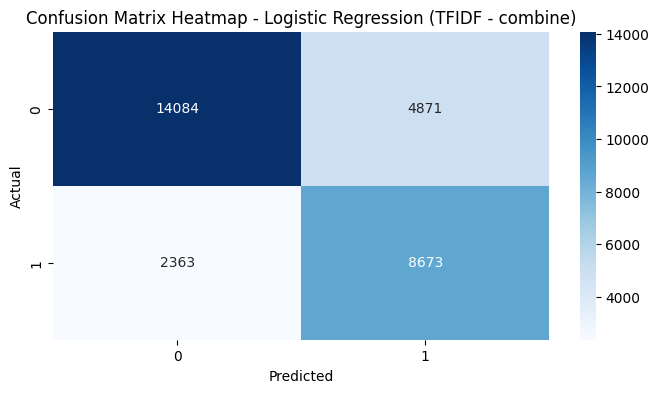

In [72]:
## confusion matrix
plt.figure(figsize=(8,4))
cf_matrix=confusion_matrix(y_test_tfidf_combine,y_test_predict_log_tfidf_combine)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model_log_tfidf_combine.classes_,
            yticklabels=model_log_tfidf_combine.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap - Logistic Regression (TFIDF - combine)')
plt.show()

## Random Forest 

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
## tfidf 
model_rfc_tfidf_combine = RandomForestClassifier(max_features='sqrt',n_jobs=-1,verbose = 10,
                                         random_state=11,class_weight='balanced')
model_rfc_tfidf_diff = RandomForestClassifier(max_features='sqrt',n_jobs=-1,verbose = 10,
                                         random_state=11,class_weight='balanced')
## tfidf pca 
model_rfc_tfidf_pca_combine = RandomForestClassifier(max_features='sqrt',n_jobs=-1,verbose = 10,
                                         random_state=11,class_weight='balanced')
model_rfc_tfidf_pca_diff = RandomForestClassifier(max_features='sqrt',n_jobs=-1,verbose = 10,
                                         random_state=11,class_weight='balanced')

In [75]:
## word2vec
model_rfc_w2vec_combine = RandomForestClassifier(max_features='sqrt',n_jobs=-1,verbose = 10,
                                         random_state=11,class_weight='balanced')
model_rfc_w2vec_diff = RandomForestClassifier(max_features='sqrt',n_jobs=-1,verbose = 10,
                                         random_state=11,class_weight='balanced')

In [76]:
# Define the hyperparameter grid
param_grid_rfc = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the gridsearch
grid_search_rfc = GridSearchCV(estimator=model_rfc_tfidf_combine, param_grid=param_grid_rfc, 
                           cv=3, n_jobs=-1, scoring='f1', verbose=10)

# Fit the model
#grid_search_rfc.fit(x_train_tfidf,y_train_tfidf)

# Predict the labels
#predicted_labels = random_search.predict(X_test)

#best_params_rfc = grid_search_rfc.best_params_
# Evaluate the model
#print(f"Best parameters: {best_params_rfc}")

In [77]:
# Save the best model to a pickle file

#with open('best_model_rfc.pkl', 'wb') as f:
    #pickle.dump(grid_search_rfc.best_estimator_, f)

In [78]:
# Load the best model from the pickle file
#with open('best_model_rfc.pkl', 'rb') as f:
    #best_model_rfc = pickle.load(f)

# Use the loaded model to predict the labels
#y_test_predict_rfc = best_model_rfc.predict(x_test_tfidf)

In [79]:
## TFIDF embedding - combine
model_rfc_tfidf_combine.fit(x_train_tfidf_combine,y_train_tfidf_combine)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s


building tree 19 of 100building tree 20 of 100

building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.2s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.0s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.3s


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   25.8s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   30.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.9s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=11,
                       verbose=10)

In [80]:
## TFIDF embedding - diff
model_rfc_tfidf_diff.fit(x_train_tfidf_diff,y_train_tfidf_diff)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s


building tree 25 of 100building tree 26 of 100

building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100building tree 34 of 100

building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100building tree 50 of 100

building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.3s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.3s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.0s


building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   17.0s


building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   18.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.1s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=11,
                       verbose=10)

In [81]:
## TFIDF embedding - pca combine
model_rfc_tfidf_pca_combine.fit(x_train_tfidf_pca_combine,y_train_tfidf_pca_combine)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.9s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.6s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.1s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.8s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   23.1s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   27.8s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   34.6s


building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   39.7s


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   46.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.6s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=11,
                       verbose=10)

In [82]:
## TFIDF embedding - pca diff
model_rfc_tfidf_pca_diff.fit(x_train_tfidf_pca_diff,y_train_tfidf_pca_diff)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s


building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.6s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.9s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.8s


building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   18.5s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   21.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.8s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=11,
                       verbose=10)

In [83]:
## word2vec embedding - combine
model_rfc_w2vec_combine.fit(x_train_w2vec_combine,y_train_w2vec_combine)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.8s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.7s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   19.8s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   25.3s


building tree 65 of 100building tree 66 of 100

building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   30.4s


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   36.7s


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   42.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.3s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=11,
                       verbose=10)

In [84]:
## word2vec embedding - diff
model_rfc_w2vec_diff.fit(x_train_w2vec_diff,y_train_w2vec_diff)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.8s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.1s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.8s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   23.4s


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   27.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.7s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=11,
                       verbose=10)

In [85]:
## tfidf
y_test_predict_rfc_tfidf_combine = model_rfc_tfidf_combine.predict(x_test_tfidf_combine)
y_test_prob_predict_rfc_tfidf_combine = model_rfc_tfidf_combine.predict_proba(x_test_tfidf_combine)

y_test_predict_rfc_tfidf_diff = model_rfc_tfidf_diff.predict(x_test_tfidf_diff)
y_test_prob_predict_rfc_tfidf_diff = model_rfc_tfidf_diff.predict_proba(x_test_tfidf_diff)

## tfidf pca
y_test_predict_rfc_tfidf_pca_combine = model_rfc_tfidf_pca_combine.predict(x_test_tfidf_pca_combine)
y_test_prob_predict_rfc_tfidf_pca_combine = model_rfc_tfidf_pca_combine.predict_proba(x_test_tfidf_pca_combine)

y_test_predict_rfc_tfidf_pca_diff = model_rfc_tfidf_pca_diff.predict(x_test_tfidf_pca_diff)
y_test_prob_predict_rfc_tfidf_pca_diff = model_rfc_tfidf_pca_diff.predict_proba(x_test_tfidf_pca_diff)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)

In [86]:
## word2vec
y_test_predict_rfc_w2vec_combine = model_rfc_w2vec_combine.predict(x_test_w2vec_combine)
y_test_prob_predict_rfc_w2vec_combine = model_rfc_w2vec_combine.predict_proba(x_test_w2vec_combine)

y_test_predict_rfc_w2vec_diff = model_rfc_w2vec_diff.predict(x_test_w2vec_diff)
y_test_prob_predict_rfc_w2vec_diff = model_rfc_w2vec_diff.predict_proba(x_test_w2vec_diff)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)

In [87]:
## model evaluation
#f_score_rfc_tfidf = f1_score(y_test_tfidf,y_test_predict_rfc_tfidf)
print("-------------------------------------------------------------")
print("TFIDF emdedding - Combine")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_combine,y_test_predict_rfc_tfidf_combine))
print("-------------------------------------------------------------")

print("TFIDF emdedding - Diff")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_diff,y_test_predict_rfc_tfidf_diff))
print("-------------------------------------------------------------")

print("TFIDF emdedding - PCA combine")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_pca_combine,y_test_predict_rfc_tfidf_pca_combine))
print("-------------------------------------------------------------")

print("TFIDF emdedding - PCA diff")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_pca_diff,y_test_predict_rfc_tfidf_pca_diff))

-------------------------------------------------------------
TFIDF emdedding - Combine
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     18955
           1       0.72      0.70      0.71     11036

    accuracy                           0.79     29991
   macro avg       0.77      0.77      0.77     29991
weighted avg       0.79      0.79      0.79     29991

-------------------------------------------------------------
TFIDF emdedding - Diff
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     18955
           1       0.70      0.65      0.67     11036

    accuracy                           0.77     29991
   macro avg       0.75      0.74      0.75     29991
weighted avg       0.76      0.77      0.77     29991

-------------------------------------------------

In [88]:
#f_score_log_w2vec = f1_score(y_test_w2vec,y_test_predict_log_w2vec)
print("-------------------------------------------------------------")
print("Word2vec emdedding - combine")
print("-------------------------------------------------------------")
print(classification_report(y_test_w2vec_combine,y_test_predict_rfc_w2vec_combine))
print("-------------------------------------------------------------")

print("Word2vec emdedding - diff")
print("-------------------------------------------------------------")
print(classification_report(y_test_w2vec_diff,y_test_predict_rfc_w2vec_diff))

-------------------------------------------------------------
Word2vec emdedding - combine
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     18955
           1       0.75      0.53      0.62     11036

    accuracy                           0.76     29991
   macro avg       0.76      0.72      0.73     29991
weighted avg       0.76      0.76      0.75     29991

-------------------------------------------------------------
Word2vec emdedding - diff
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.87      0.80     18955
           1       0.69      0.49      0.57     11036

    accuracy                           0.73     29991
   macro avg       0.72      0.68      0.69     29991
weighted avg       0.72      0.73      0.72     29991



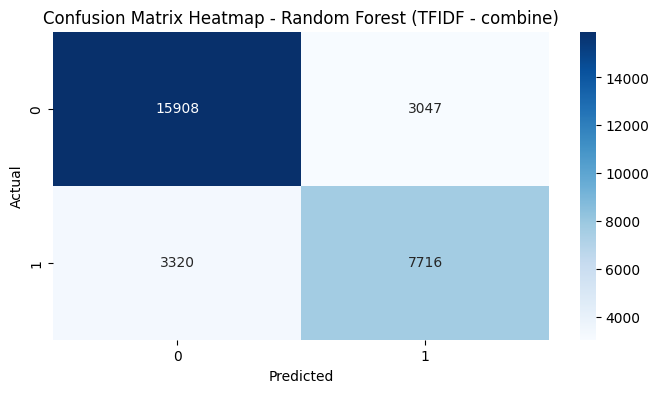

In [89]:
## confusion matrix
plt.figure(figsize=(8,4))
cf_matrix=confusion_matrix(y_test_tfidf_combine,y_test_predict_rfc_tfidf_combine)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model_rfc_tfidf_combine.classes_,
            yticklabels=model_rfc_tfidf_combine.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap - Random Forest (TFIDF - combine)')
plt.show()

## XGBoost

In [90]:
import xgboost as xgb

In [91]:
y_train_tfidf_combine.value_counts(),y_train_tfidf_diff.value_counts()

(0    44228
 1    25748
 Name: is_duplicate, dtype: int64,
 0    44228
 1    25748
 Name: is_duplicate, dtype: int64)

In [92]:
#y_train_w2vec_combine.value_counts(),y_train_w2vec_diff.value_counts()

In [93]:
scale_pos_weight_xgb = y_train_tfidf_combine.value_counts()[0]/y_train_tfidf_combine.value_counts()[1]
scale_pos_weight_xgb

1.7177256485940655

In [94]:
## tfidf 
model_xgb_tfidf_combine = xgb.XGBClassifier(n_jobs=-1,scale_pos_weight = scale_pos_weight_xgb,verbose = 10)
model_xgb_tfidf_diff = xgb.XGBClassifier(n_jobs=-1,scale_pos_weight = scale_pos_weight_xgb,verbose = 10)

## tfidf pca 
model_xgb_tfidf_pca_combine = xgb.XGBClassifier(n_jobs=-1,scale_pos_weight = scale_pos_weight_xgb,verbose = 10)
model_xgb_tfidf_pca_diff = xgb.XGBClassifier(n_jobs=-1,scale_pos_weight = scale_pos_weight_xgb,verbose = 10)

In [95]:
## word2vec
model_xgb_w2vec_combine = xgb.XGBClassifier(n_jobs=-1,scale_pos_weight = scale_pos_weight_xgb,verbose = 10)
model_xgb_w2vec_diff = xgb.XGBClassifier(n_jobs=-1,scale_pos_weight = scale_pos_weight_xgb,verbose = 10)

In [96]:
# Define the hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

In [97]:
# Define the gridsearch
grid_search_xgb = GridSearchCV(estimator=model_xgb_tfidf_combine, param_grid=param_grid_xgb, 
                           cv=3, n_jobs=-1, scoring='f1', verbose=10)

# Fit the model
#grid_search_xgb.fit(x_train_tfidf,y_train_tfidf)

# Predict the labels
#predicted_labels = grid_search_xgb.predict(x_test)

#best_params_xgb = grid_search_xgb.best_params_
# Evaluate the model
#print(f"Best parameters: {best_params_xgb}")

In [98]:
# Save the best model to a pickle file

#with open('best_model_xgb.pkl', 'wb') as f:
    #pickle.dump(grid_search_xgb.best_estimator_, f)

In [99]:
# Load the best model from the pickle file
#with open('best_model_xgb.pkl', 'rb') as f:
    #best_model_xgb = pickle.load(f)

# Use the loaded model to predict the labels
#y_test_predict_xgb = best_model_xgb.predict(x_test_tfidf)

In [100]:
## TFIDF embedding - combine
model_xgb_tfidf_combine.fit(x_train_tfidf_combine,y_train_tfidf_combine)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [101]:
## TFIDF embedding - diff
model_xgb_tfidf_diff.fit(x_train_tfidf_diff,y_train_tfidf_diff)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [102]:
## TFIDF embedding - pca combine
model_xgb_tfidf_pca_combine.fit(x_train_tfidf_pca_combine,y_train_tfidf_pca_combine)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [103]:
## TFIDF embedding - pca diff
model_xgb_tfidf_pca_diff.fit(x_train_tfidf_pca_diff,y_train_tfidf_pca_diff)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [104]:
## w2vec embedding - combine
model_xgb_w2vec_combine.fit(x_train_w2vec_combine,y_train_w2vec_combine)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [105]:
## w2vec embedding - diff
model_xgb_w2vec_diff.fit(x_train_w2vec_diff,y_train_w2vec_diff)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [106]:
## tfidf
y_test_predict_xgb_tfidf_combine = model_xgb_tfidf_combine.predict(x_test_tfidf_combine)
y_test_prob_predict_xgb_tfidf_combine = model_xgb_tfidf_combine.predict_proba(x_test_tfidf_combine)

y_test_predict_xgb_tfidf_diff = model_xgb_tfidf_diff.predict(x_test_tfidf_diff)
y_test_prob_predict_xgb_tfidf_diff = model_xgb_tfidf_diff.predict_proba(x_test_tfidf_diff)

## tfidf pca
y_test_predict_xgb_tfidf_pca_combine = model_xgb_tfidf_pca_combine.predict(x_test_tfidf_pca_combine)
y_test_prob_predict_xgb_tfidf_pca_combine = model_xgb_tfidf_pca_combine.predict_proba(x_test_tfidf_pca_combine)

y_test_predict_xgb_tfidf_pca_diff = model_xgb_tfidf_pca_diff.predict(x_test_tfidf_pca_diff)
y_test_prob_predict_xgb_tfidf_pca_diff = model_xgb_tfidf_pca_diff.predict_proba(x_test_tfidf_pca_diff)

In [107]:
## word2vec
y_test_predict_xgb_w2vec_combine = model_xgb_w2vec_combine.predict(x_test_w2vec_combine)
y_test_prob_predict_xgb_w2vec_combine = model_xgb_w2vec_combine.predict_proba(x_test_w2vec_combine)

y_test_predict_xgb_w2vec_diff = model_xgb_w2vec_diff.predict(x_test_w2vec_diff)
y_test_prob_predict_xgb_w2vec_diff = model_xgb_w2vec_diff.predict_proba(x_test_w2vec_diff)

In [108]:
## model evaluation
#f_score_rfc_tfidf = f1_score(y_test_tfidf,y_test_predict_rfc_tfidf)
print("-------------------------------------------------------------")
print("TFIDF emdedding - Combine")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_combine,y_test_predict_xgb_tfidf_combine))
print("-------------------------------------------------------------")

print("TFIDF emdedding - Diff")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_diff,y_test_predict_xgb_tfidf_diff))
print("-------------------------------------------------------------")

print("TFIDF emdedding - PCA combine")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_pca_combine,y_test_predict_xgb_tfidf_pca_combine))
print("-------------------------------------------------------------")

print("TFIDF emdedding - PCA diff")
print("-------------------------------------------------------------")
print(classification_report(y_test_tfidf_pca_diff,y_test_predict_xgb_tfidf_pca_diff))

-------------------------------------------------------------
TFIDF emdedding - Combine
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.73      0.80     18955
           1       0.64      0.83      0.73     11036

    accuracy                           0.77     29991
   macro avg       0.76      0.78      0.76     29991
weighted avg       0.79      0.77      0.77     29991

-------------------------------------------------------------
TFIDF emdedding - Diff
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.70      0.78     18955
           1       0.62      0.84      0.71     11036

    accuracy                           0.75     29991
   macro avg       0.75      0.77      0.75     29991
weighted avg       0.78      0.75      0.75     29991

-------------------------------------------------

In [109]:
#f_score_log_w2vec = f1_score(y_test_w2vec,y_test_predict_log_w2vec)
print("-------------------------------------------------------------")
print("Word2vec emdedding - combine")
print("-------------------------------------------------------------")
print(classification_report(y_test_w2vec_combine,y_test_predict_xgb_w2vec_combine))
print("-------------------------------------------------------------")

print("Word2vec emdedding - diff")
print("-------------------------------------------------------------")
print(classification_report(y_test_w2vec_diff,y_test_predict_xgb_w2vec_diff))

-------------------------------------------------------------
Word2vec emdedding - combine
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.74      0.79     18955
           1       0.64      0.77      0.70     11036

    accuracy                           0.75     29991
   macro avg       0.74      0.76      0.74     29991
weighted avg       0.77      0.75      0.76     29991

-------------------------------------------------------------
Word2vec emdedding - diff
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.70      0.76     18955
           1       0.60      0.77      0.68     11036

    accuracy                           0.73     29991
   macro avg       0.72      0.74      0.72     29991
weighted avg       0.75      0.73      0.73     29991



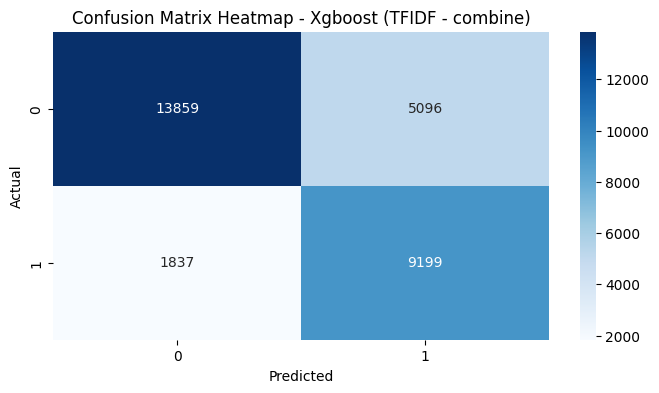

In [110]:
## confusion matrix
plt.figure(figsize=(8,4))
cf_matrix=confusion_matrix(y_test_tfidf_combine,y_test_predict_xgb_tfidf_combine)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model_xgb_tfidf_combine.classes_,
            yticklabels=model_xgb_tfidf_combine.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap - Xgboost (TFIDF - combine)')
plt.show()

In [111]:
model_name = ['Logistic Regression - (TFIDF Combine)','Logistic Regression - (TFIDF Diff)',
              'Logistic Regression - (TFIDF PCA Combine)','Logistic Regression - (TFIDF PCA Diff)',
              'Logistic Regression - (W2vec Combine)','Logistic Regression - (W2vec Diff)',
              'Random Forest - (TFIDF Combine)','Random Forest - (TFIDF Diff)',
              'Random Forest - (TFIDF PCA Combine)','Random Forest - (TFIDF PCA Diff)',
              'Random Forest - (W2vec Combine)','Random Forest - (W2vec Diff)',
              'XGBOOST - (TFIDF Combine)','XGBOOST - (TFIDF Diff)',
              'XGBOOST - (TFIDF PCA Combine)','XGBOOST - (TFIDF PCA Diff)',
              'XGBOOST - (W2vec Combine)','XGBOOST - (W2vec Diff)',
              ]

In [112]:
accuracy_metric = [round(accuracy_score(y_test_tfidf_combine,y_test_predict_log_tfidf_combine),3),
           round(accuracy_score(y_test_tfidf_diff,y_test_predict_log_tfidf_diff),3),
           round(accuracy_score(y_test_tfidf_pca_combine,y_test_predict_log_tfidf_pca_combine),3),
           round(accuracy_score(y_test_tfidf_pca_diff,y_test_predict_log_tfidf_pca_diff),3),
           round(accuracy_score(y_test_w2vec_combine,y_test_predict_log_w2vec_combine),3),
           round(accuracy_score(y_test_w2vec_diff,y_test_predict_log_w2vec_diff),3),
                   
           round(accuracy_score(y_test_tfidf_combine,y_test_predict_rfc_tfidf_combine),3),
           round(accuracy_score(y_test_tfidf_diff,y_test_predict_rfc_tfidf_diff),3),
           round(accuracy_score(y_test_tfidf_pca_combine,y_test_predict_rfc_tfidf_pca_combine),3),
           round(accuracy_score(y_test_tfidf_pca_diff,y_test_predict_rfc_tfidf_pca_diff),3),
           round(accuracy_score(y_test_w2vec_combine,y_test_predict_rfc_w2vec_combine),3),
           round(accuracy_score(y_test_w2vec_diff,y_test_predict_rfc_w2vec_diff),3),
            
           round(accuracy_score(y_test_tfidf_combine,y_test_predict_xgb_tfidf_combine),3),
           round(accuracy_score(y_test_tfidf_diff,y_test_predict_xgb_tfidf_diff),3),
           round(accuracy_score(y_test_tfidf_pca_combine,y_test_predict_xgb_tfidf_pca_combine),3),
           round(accuracy_score(y_test_tfidf_pca_diff,y_test_predict_xgb_tfidf_pca_diff),3),
           round(accuracy_score(y_test_w2vec_combine,y_test_predict_xgb_w2vec_combine),3),
           round(accuracy_score(y_test_w2vec_diff,y_test_predict_xgb_w2vec_diff),3)
            ]

In [113]:
precision_metric = [round(precision_score(y_test_tfidf_combine,y_test_predict_log_tfidf_combine),3),
           round(precision_score(y_test_tfidf_diff,y_test_predict_log_tfidf_diff),3),
           round(precision_score(y_test_tfidf_pca_combine,y_test_predict_log_tfidf_pca_combine),3),
           round(precision_score(y_test_tfidf_pca_diff,y_test_predict_log_tfidf_pca_diff),3),
           round(precision_score(y_test_w2vec_combine,y_test_predict_log_w2vec_combine),3),
           round(precision_score(y_test_w2vec_diff,y_test_predict_log_w2vec_diff),3),
                    
           round(precision_score(y_test_tfidf_combine,y_test_predict_rfc_tfidf_combine),3),
           round(precision_score(y_test_tfidf_diff,y_test_predict_rfc_tfidf_diff),3),
           round(precision_score(y_test_tfidf_pca_combine,y_test_predict_rfc_tfidf_pca_combine),3),
           round(precision_score(y_test_tfidf_pca_diff,y_test_predict_rfc_tfidf_pca_diff),3),
           round(precision_score(y_test_w2vec_combine,y_test_predict_rfc_w2vec_combine),3),
           round(precision_score(y_test_w2vec_diff,y_test_predict_rfc_w2vec_diff),3),
                    
            round(precision_score(y_test_tfidf_combine,y_test_predict_xgb_tfidf_combine),3),
           round(precision_score(y_test_tfidf_diff,y_test_predict_xgb_tfidf_diff),3),
           round(precision_score(y_test_tfidf_pca_combine,y_test_predict_xgb_tfidf_pca_combine),3),
           round(precision_score(y_test_tfidf_pca_diff,y_test_predict_xgb_tfidf_pca_diff),3),
           round(precision_score(y_test_w2vec_combine,y_test_predict_xgb_w2vec_combine),3),
           round(precision_score(y_test_w2vec_diff,y_test_predict_xgb_w2vec_diff),3)
            ]

In [114]:
recall_metric = [round(recall_score(y_test_tfidf_combine,y_test_predict_log_tfidf_combine),3),
           round(recall_score(y_test_tfidf_diff,y_test_predict_log_tfidf_diff),3),
           round(recall_score(y_test_tfidf_pca_combine,y_test_predict_log_tfidf_pca_combine),3),
           round(recall_score(y_test_tfidf_pca_diff,y_test_predict_log_tfidf_pca_diff),3),
           round(recall_score(y_test_w2vec_combine,y_test_predict_log_w2vec_combine),3),
           round(recall_score(y_test_w2vec_diff,y_test_predict_log_w2vec_diff),3),
                
           round(recall_score(y_test_tfidf_combine,y_test_predict_rfc_tfidf_combine),3),
           round(recall_score(y_test_tfidf_diff,y_test_predict_rfc_tfidf_diff),3),
           round(recall_score(y_test_tfidf_pca_combine,y_test_predict_rfc_tfidf_pca_combine),3),
           round(recall_score(y_test_tfidf_pca_diff,y_test_predict_rfc_tfidf_pca_diff),3),
           round(recall_score(y_test_w2vec_combine,y_test_predict_rfc_w2vec_combine),3),
           round(recall_score(y_test_w2vec_diff,y_test_predict_rfc_w2vec_diff),3),
                
                
           round(recall_score(y_test_tfidf_combine,y_test_predict_xgb_tfidf_combine),3),
           round(recall_score(y_test_tfidf_diff,y_test_predict_xgb_tfidf_diff),3),
           round(recall_score(y_test_tfidf_pca_combine,y_test_predict_xgb_tfidf_pca_combine),3),
           round(recall_score(y_test_tfidf_pca_diff,y_test_predict_xgb_tfidf_pca_diff),3),
           round(recall_score(y_test_w2vec_combine,y_test_predict_xgb_w2vec_combine),3),
           round(recall_score(y_test_w2vec_diff,y_test_predict_xgb_w2vec_diff),3)
            ]

In [115]:
f1_metric = [round(f1_score(y_test_tfidf_combine,y_test_predict_log_tfidf_combine),3),
           round(f1_score(y_test_tfidf_diff,y_test_predict_log_tfidf_diff),3),
           round(f1_score(y_test_tfidf_pca_combine,y_test_predict_log_tfidf_pca_combine),3),
           round(f1_score(y_test_tfidf_pca_diff,y_test_predict_log_tfidf_pca_diff),3),
           round(f1_score(y_test_w2vec_combine,y_test_predict_log_w2vec_combine),3),
           round(f1_score(y_test_w2vec_diff,y_test_predict_log_w2vec_diff),3),
            
           round(f1_score(y_test_tfidf_combine,y_test_predict_rfc_tfidf_combine),3),
           round(f1_score(y_test_tfidf_diff,y_test_predict_rfc_tfidf_diff),3),
           round(f1_score(y_test_tfidf_pca_combine,y_test_predict_rfc_tfidf_pca_combine),3),
           round(f1_score(y_test_tfidf_pca_diff,y_test_predict_rfc_tfidf_pca_diff),3),
           round(f1_score(y_test_w2vec_combine,y_test_predict_rfc_w2vec_combine),3),
           round(f1_score(y_test_w2vec_diff,y_test_predict_rfc_w2vec_diff),3),
             
             round(f1_score(y_test_tfidf_combine,y_test_predict_xgb_tfidf_combine),3),
           round(f1_score(y_test_tfidf_diff,y_test_predict_xgb_tfidf_diff),3),
           round(f1_score(y_test_tfidf_pca_combine,y_test_predict_xgb_tfidf_pca_combine),3),
           round(f1_score(y_test_tfidf_pca_diff,y_test_predict_xgb_tfidf_pca_diff),3),
           round(f1_score(y_test_w2vec_combine,y_test_predict_xgb_w2vec_combine),3),
           round(f1_score(y_test_w2vec_diff,y_test_predict_xgb_w2vec_diff),3),
            ]

In [116]:
df_metrics  = pd.DataFrame({'Model Name': model_name,'Accuracy': accuracy_metric,
                           'Precision':precision_metric,'Recall':recall_metric,
                           'f1 Score':f1_metric})

## Results Comparison

In [117]:
df_metrics

,Model Name,Accuracy,Precision,Recall,f1 Score
0,Logistic Regression - (TFIDF Combine),0.759,0.640,0.786,0.706
1,Logistic Regression - (TFIDF Diff),0.682,0.550,0.736,0.630
2,Logistic Regression - (TFIDF PCA Combine),0.750,0.629,0.781,0.697
3,Logistic Regression - (TFIDF PCA Diff),0.681,0.550,0.735,0.629
4,Logistic Regression - (W2vec Combine),0.697,0.567,0.746,0.645
5,Logistic Regression - (W2vec Diff),0.684,0.553,0.739,0.632
6,Random Forest - (TFIDF Combine),0.788,0.717,0.699,0.708
7,Random Forest - (TFIDF Diff),0.767,0.697,0.650,0.673
8,Random Forest - (TFIDF PCA Combine),0.777,0.793,0.533,0.638
9,Random Forest - (TFIDF PCA Diff),0.738,0.719,0.475,0.572
